We are often asked how to organise a code for tasks such as:
* performing the same analysis on different models or grid resolutions
* performing an analysis on each season

The principle to apply in all cases is to avoid repeating code. In Python and most of other programming languages, to avoid repetition one can use dictionaries and/or functions and/or classes.

In this blog, we are going to use a small example to illustrate those techniques. Those techniques can often be used interchangeably. Usually, functions and classes result in more flexible and reusable code.

Note: the analysis chosen here does not need to use dictionaries and functions to be done. We only do so here to illustrate the generic process. The direct way to perform the analysis is noted at the end of this notebook.

In [1]:
import xarray as xr
import numpy as np
from pathlib import Path

# Badly organised code
The following code is correct as it gives the correct answer but it is prone to errors because code is repeated. This increases the risk of typos. For more complex analyses, it can also make it harder to test as it is not modular.

In [2]:
# Get the data we need

# Paths to 2 CMIP6 model experiments
IPSL_path = Path("/g/data/oi10/replicas/CMIP6/CMIP/IPSL/IPSL-CM5A2-INCA/")
historical_path = IPSL_path/"historical/r1i1p1f1/Lmon/tsl/gr/v20200729/"
picontrol_path  = IPSL_path/"piControl/r1i1p1f1/Lmon/tsl/gr/v20210216/"
# Find all netcdf files in those directories. 
historical_path = sorted(historical_path.glob("*.nc"))
picontrol_path  = sorted(picontrol_path.glob("*.nc"))

historical_ds = xr.open_mfdataset(historical_path)
picontrol_ds  = xr.open_mfdataset(picontrol_path)

# Load the data as it is small and select the surface only
historical_tsl = historical_ds["tsl"].isel(solth=0).load()
picontrol_tsl  = picontrol_ds["tsl"].isel(solth=0).load()

# Restrict the data to the longest common time window.
picontrol_tsl = picontrol_tsl.sel(time=historical_tsl.time)

# Use display() to get a nice display of the DataArray instead of print()
display(historical_tsl)
display(picontrol_tsl)

<xarray.DataArray 'tsl' (time: 1980, lat: 96, lon: 96)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 360.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
    solth    float32 0.01419
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    long_name:           Temperature of Soil
    units:               K
    online_operation:    average
    cell_methods:        area: mean where land time: mean
    interval_operation:  1800 s
    interval_write:      1 month
    standard_name:       soil_temperature
    description:         Temperature of each soil layer.  Reported as "missin...
    history:             none
    cell_measures:       area: areacella

<xarray.DataArray 'tsl' (time: 1980, lat: 96, lon: 96)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 360.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
    solth    float32 0.01419
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    long_name:           Temperature of Soil
    units:               K
    online_operation:    average
    cell_methods:        area: mean where land time: mean
    interval_operation:  1800 s
    interval_write:      1 month
    standard_name:       soil_temperature
    description:         Temperature of each soil layer.  Reported as "missin...
    history:             none
    cell_measures:       area: areacella

In [3]:
# Do our analysis: calculate a percentile for each season
time = historical_tsl.time
hist_pct_djf = historical_tsl.where(time.dt.season == 'DJF').quantile(0.9, dim=["time"])
hist_pct_mam = historical_tsl.where(time.dt.season == 'MAM').quantile(0.9, dim=["time"])
hist_pct_jja = historical_tsl.where(time.dt.season == 'JJA').quantile(0.9, dim=["time"])
hist_pct_son = historical_tsl.where(time.dt.season == 'SON').quantile(0.9, dim=["time"])
pic_pct_djf  = picontrol_tsl.where(time.dt.season == 'DJF').quantile(0.9, dim=["time"])
pic_pct_mam  = picontrol_tsl.where(time.dt.season == 'MAM').quantile(0.9, dim=["time"])
pic_pct_jja  = picontrol_tsl.where(time.dt.season == 'JJA').quantile(0.9, dim=["time"])
pic_pct_son  = picontrol_tsl.where(time.dt.season == 'SON').quantile(0.9, dim=["time"])

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarni

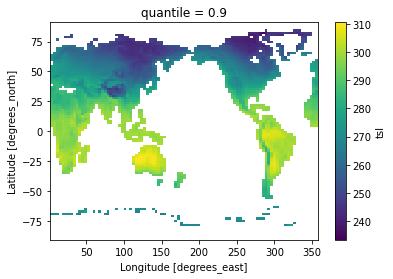

In [4]:
# Plot one of the results. We remove the first longitude because 
hist_pct_djf.isel(lon=slice(1,None)).plot()

As you can see the code has a lot of similar lines with only an option that changes between the lines. It was quite long to write as each time I had to be careful to use the correct name. We'll see other ways to which are more compact and faster to write.

# Better code structure

In [5]:
# Define a function to read in the data
def get_var(path, varname):
    """Reads in all the netcdf files in the input path and return the data for the selected variable
    path: pathlib.Path, path to the netcdf files
    varname: string, name of the variable to select in the netcdf files"""
    
    netcdf_files = sorted(path.glob("*.nc"))
    ds = xr.open_mfdataset(netcdf_files)
    
    return ds[varname]

In [6]:
# Define dictionaries for the experiments so we can keep all the information about 1 experiment
# in the same structure.
historical = {}
picontrol  = {}

IPSL_path = Path("/g/data/oi10/replicas/CMIP6/CMIP/IPSL/IPSL-CM5A2-INCA/")
historical["path"] = IPSL_path/"historical/r1i1p1f1/Lmon/tsl/gr/v20200729/"
picontrol["path"]  = IPSL_path/"piControl/r1i1p1f1/Lmon/tsl/gr/v20210216/"

historical["tsl"] = get_var(historical["path"], "tsl")
picontrol["tsl"]  = get_var(picontrol["path"],"tsl")

# Load the data as it is small and select the surface only
historical["tsl"] = historical["tsl"].isel(solth=0).load()
picontrol["tsl"]  = picontrol["tsl"].isel(solth=0).load()

# Restrict the data to the longest common time window.
picontrol["tsl"] = picontrol["tsl"].sel(time=historical["tsl"].time)

# Use display() to get a nice display of the DataArray instead of print()
display(historical["tsl"])
display(picontrol["tsl"])

<xarray.DataArray 'tsl' (time: 1980, lat: 96, lon: 96)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 360.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
    solth    float32 0.01419
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    long_name:           Temperature of Soil
    units:               K
    online_operation:    average
    cell_methods:        area: mean where land time: mean
    interval_operation:  1800 s
    interval_write:      1 month
    standard_name:       soil_temperature
    description:         Temperature of each soil layer.  Reported as "missin...
    history:             none
    cell_measures:       area: areacella

<xarray.DataArray 'tsl' (time: 1980, lat: 96, lon: 96)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 360.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
    solth    float32 0.01419
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    long_name:           Temperature of Soil
    units:               K
    online_operation:    average
    cell_methods:        area: mean where land time: mean
    interval_operation:  1800 s
    interval_write:      1 month
    standard_name:       soil_temperature
    description:         Temperature of each soil layer.  Reported as "missin...
    history:             none
    cell_measures:       area: areacella

For our analysis, we will define dictionaries and functions again. This will reduce the number of copied lines from 8 to 2.

In [7]:
# Do our analysis: calculate a percentile for each season
def season_quantile(data, quantile):
    """Calculate a quantile for each season in the input data
    
    data: DataArray, data with a dimension named 'time'
    quantile: scalar, quantile to calculate for the data"""
    
    seas_pct = {}
    for season, seas_data in data.groupby('time.season'):
        seas_pct[season] = seas_data.quantile(0.9, dim="time")

    return seas_pct

hist_pct_dict = season_quantile(historical["tsl"], 0.9)
pic_pct_dict  = season_quantile(picontrol["tsl"], 0.9)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


As an addition, here is how to quickly get a panel plot of all the percentiles calculated.

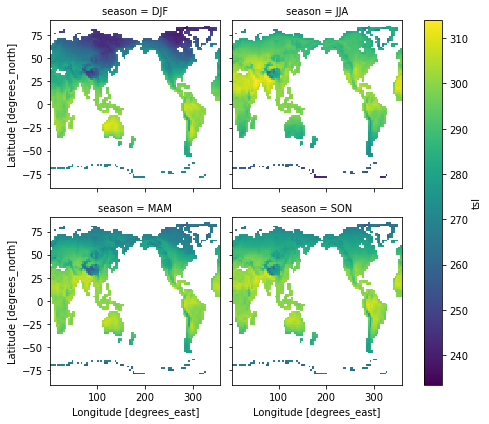

In [9]:
def dictionary_to_dataarray(input_dic, new_dim_name):
    """Concatenate the data from a dictionary to a DataArray along a new dimension.
    The keys of the dictionary are used to create a coordinate for this new dimension"""
    
    # Concatenate all the data in one DataArray along a new dimension
    da = xr.concat([data for data in input_dic.values()], dim=new_dim_name)

    # Add the dictionary keys to create a coordinate for the new dimension. 
    # Not necessary but nice to have.
    da = da.assign_coords({new_dim_name:list(input_dic.keys())})
    
    return da
    
hist_pct = dictionary_to_dataarray(hist_pct_dict, "season")

# Plot using the season dimension to create the panel plot
hist_pct.isel(lon=slice(1,None)).plot(col="season", col_wrap=2)

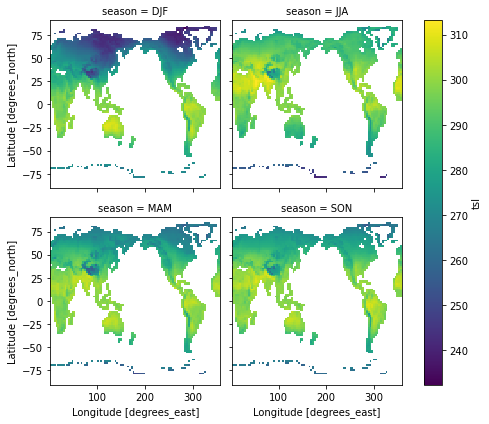

In [10]:
pic_pct = dictionary_to_dataarray(pic_pct_dict, "season")
# Plot using the season dimension to create the panel plot
pic_pct.isel(lon=slice(1,None)).plot(col="season", col_wrap=2)

Note: for this specific analysis we don't need the dictionary or function. We only do so here to create a simple example for people to understand. Normally, the seasonal quantiles can be calculated with:

`hist_pct = historical["tsl"].groupby('time.season').quantile(0.9, dim="time")`

